In [1]:
import numpy as np
import pandas as pd

import seaborn as sns  
sns.set_style("darkgrid")
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["font.sans-serif"]=["SimHei"]#展示中文字体
mpl.rcParams["axes.unicode_minus"]=False#处理负刻度值

In [2]:
data_raw = pd.read_excel("data/附件1-商家历史出货量表.xlsx")
product_type_raw = pd.read_excel("data/附件2-商品信息表.xlsx")
storage_type_raw = pd.read_excel("data/附件4-仓库信息表.xlsx")
seller_type_raw = pd.read_excel("data/附件3-商家信息表.xlsx")

In [3]:
data = data_raw.copy()
data["qty"] = data["qty"].where(data["qty"] <= 200, 200)
product_type = product_type_raw.set_index("product_no")
storage_type = storage_type_raw.drop_duplicates(keep='first').set_index("warehouse_no")
seller_type = seller_type_raw.set_index("seller_no")
seller_type["mixed type"] = seller_type["inventory_category"]+" "+seller_type["seller_level"]
seller_type.head()

,seller_category,inventory_category,seller_level,mixed type
seller_no,,,,
seller_1,居家生活,B,New,B New
seller_2,厨具,A,Large,A Large
seller_3,厨具,A,Large,A Large
seller_4,家居日用,A,Large,A Large
seller_5,家居日用,B,Large,B Large


In [7]:
data_ev_raw = pd.read_excel("data/附件6-促销期间商家出货量表.xlsx")

In [41]:
data_ev = data_ev_raw.copy()
data_ev["qty"] = data_ev["qty"].where(data_ev["qty"] <= 200, 200)
data_ev

,seller_no,product_no,warehouse_no,date,qty
0,seller_3,product_1651,wh_9,2022-11-03,0
1,seller_3,product_1651,wh_9,2022-11-08,0
2,seller_3,product_1651,wh_9,2022-11-04,1
3,seller_3,product_1651,wh_9,2022-11-06,2
4,seller_3,product_1651,wh_9,2022-11-01,2
...,...,...,...,...,...
21350,seller_28,product_762,wh_1,2022-11-08,22
21351,seller_28,product_762,wh_1,2022-11-09,28
21352,seller_27,product_671,wh_13,2022-11-10,2
21353,seller_27,product_671,wh_13,2022-11-11,1


## 分布分析

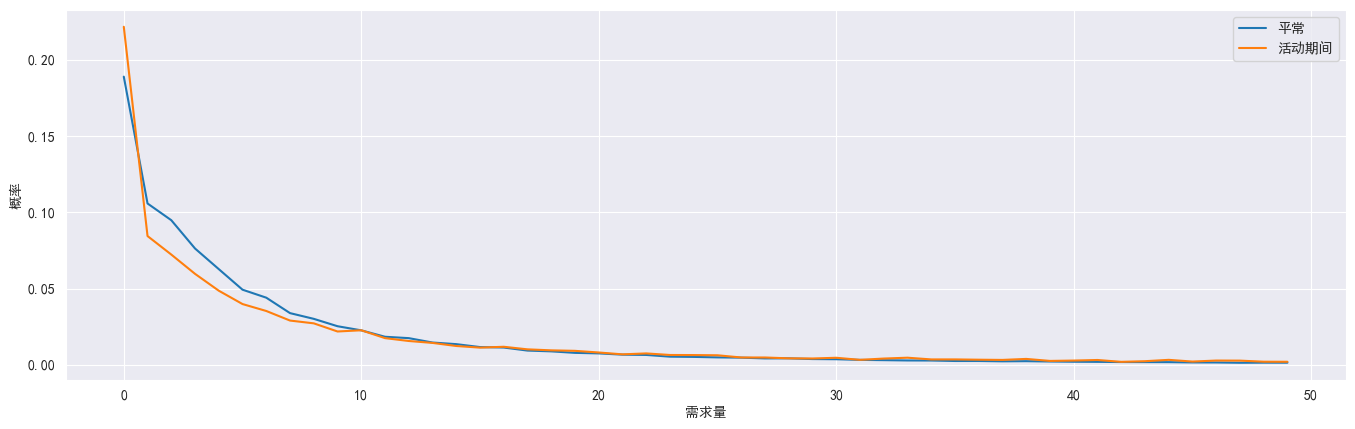

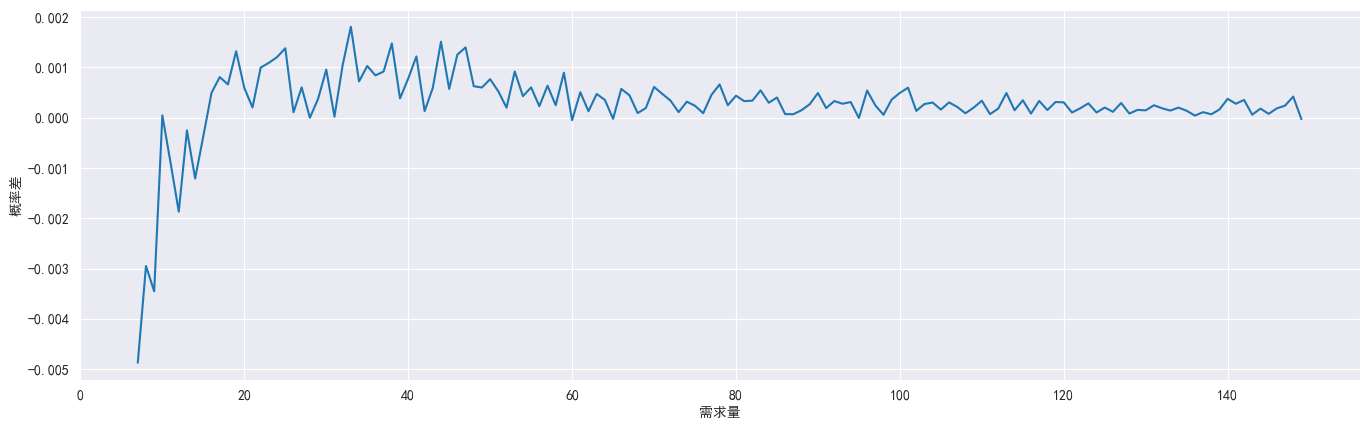

In [314]:
count1 = data[["product_no","qty"]].groupby("qty").count()
count1.columns = ["count"]
count1 /= len(data)

count2 = data_ev[["product_no","qty"]].groupby("qty").count()
count2.columns = ["count"]
count2 /= len(data_ev)

plt.plot(count1[:50], label = "平常")
plt.plot(count2[:50], label = "活动期间")
plt.xlabel("需求量")
plt.ylabel("概率")

plt.subplots_adjust(left=0, right=2)
plt.legend()
plt.show()

plt.plot(count2[7:150] - count1[7:150])
plt.xlabel("需求量")
plt.ylabel("概率差")
plt.subplots_adjust(left=0, right=2)

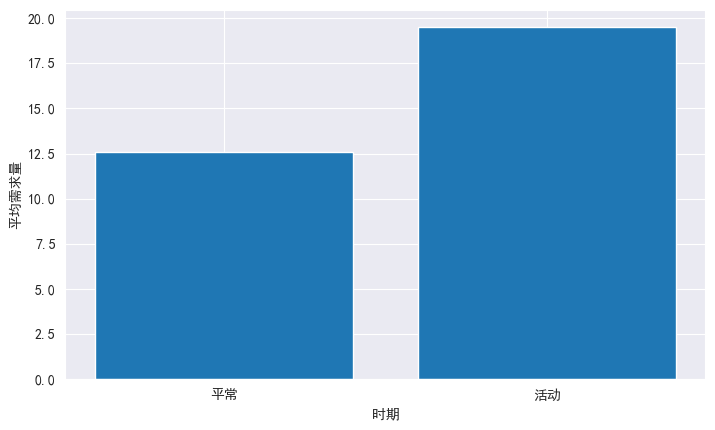

In [315]:
plt.bar(["平常","活动"], [data["qty"].mean(), data_ev["qty"].mean()])
plt.xlabel("时期")
plt.ylabel("平均需求量")
plt.subplots_adjust(left=0, right=1)

- 活动期间的需求量平均值大于平时
- 活动期间需求量<15的概率小于平时
- 活动期间需求量>15的概率大于平时

### 拟合

参考了气体分子间作用力公式

$$
p_Y-p_X=\frac{a}{r^b}－\frac{c}{r^d}~~(b＞d)
$$

- $X$为平常时期需求量的随机变量
- $Y$为活动时期需求量的随机变量

In [262]:
from scipy.optimize import curve_fit

In [263]:
def model_function(x, a, b, c, d):
    return a/x**b-c/x**d

In [264]:
begin = 4

y = (count2[begin:199]-count1[begin:199]).fillna(0).values.squeeze()
#y = np.append(y, np.zeros(20))
x = np.arange(begin,len(y)+begin).astype(float)

params, covariance = curve_fit(model_function, x, y, maxfev=8000)

# params包含拟合的参数
print(params)

[11.33955319  1.24887707 11.51234012  1.25436588]


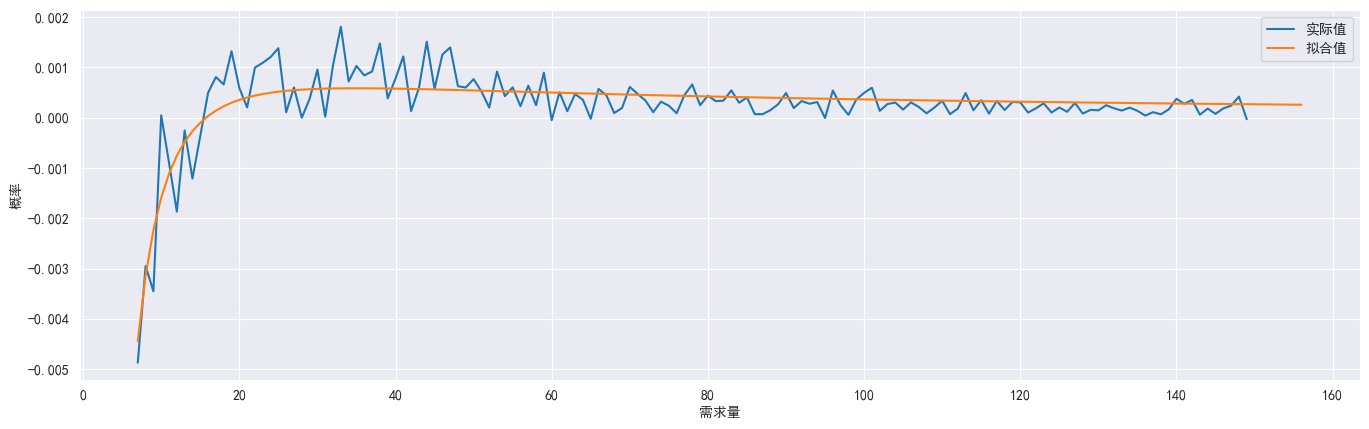

In [316]:
begin_plt = 3

tar_x = x[begin_plt:]
tar_y = model_function(x[begin_plt:], *params)

plt.plot(count2[begin+begin_plt:150] - count1[begin+begin_plt:150],label = "实际值")
plt.plot(tar_x[:150], tar_y[:150],label = "拟合值")
plt.xlabel("需求量")
plt.ylabel("概率")
plt.legend()
plt.subplots_adjust(left=0, right=2)

## 变换

找到变换函数$f$使得$f(X)$的分布近似于$Y$的分布

- $X$为平常时期需求量的随机变量
- $Y$为活动时期需求量的随机变量

$$
p_Y(x)=p_X(f^{-1}(x))\cdot |\frac{df^{-1}}{dx}|\\
$$

假设$X$和$Y$的分布为

$$
X,Y\sim p(r|a,s)=\frac{t}{r^s} + \epsilon
$$

所以
$$
p_X(x) = \frac{11.51234012}{x^{1.25436588}}\\
p_Y(x) = \frac{11.33955319}{x^{1.24887707}}
$$

In [247]:
a,b,c,d = params

In [254]:
def px(X):
    return c/X**d
def py(Y):
    return a/Y**b

假设变换函数的形式为：

$$
f(x)=kx^p
$$

根据推导，变换函数为：

$$
f^{-1}(x)=k^{-\frac1p}\cdot x^{\frac1p}\\
\frac{a}{x^b}=\frac{c}{(k^{-\frac1p}\cdot x^{\frac1p})^d}\cdot |k^{-\frac1p}\frac1px^{\frac1p-1}|
$$

In [271]:
p = (1-d)/(1-b)
k = np.power(a/c*p, (d-1)/p)

print(k,p)

1.000343875487862 1.0174371313786


$$
p=1.0272535514110483\\
k=1.0220542986463772
$$

### 验证

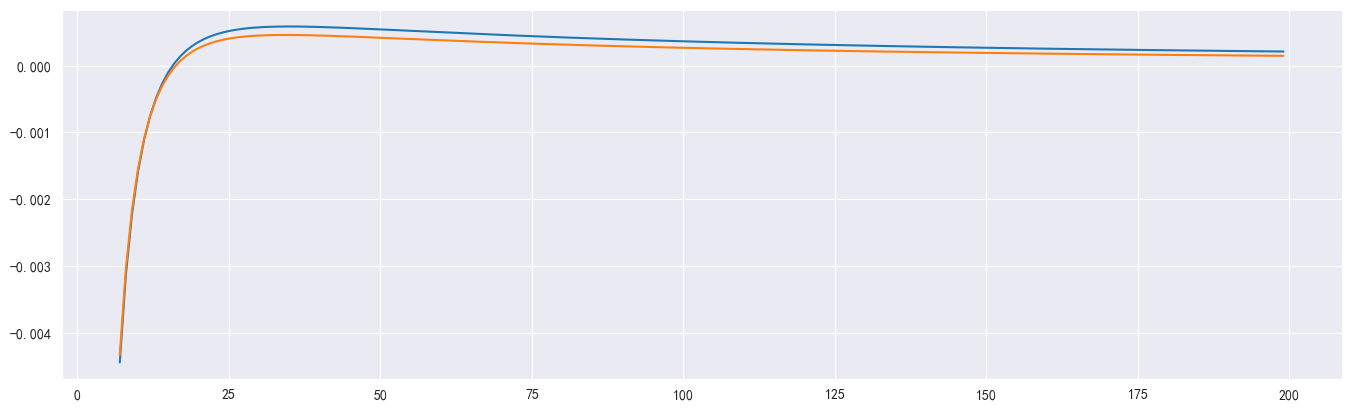

In [272]:
tar_x = x[begin_plt:]
tar_y = model_function(x[begin_plt:], *params)

plt.plot(tar_x, tar_y)
plt.plot(tar_x, py(tar_x)-px(tar_x))
plt.subplots_adjust(left=0, right=2)

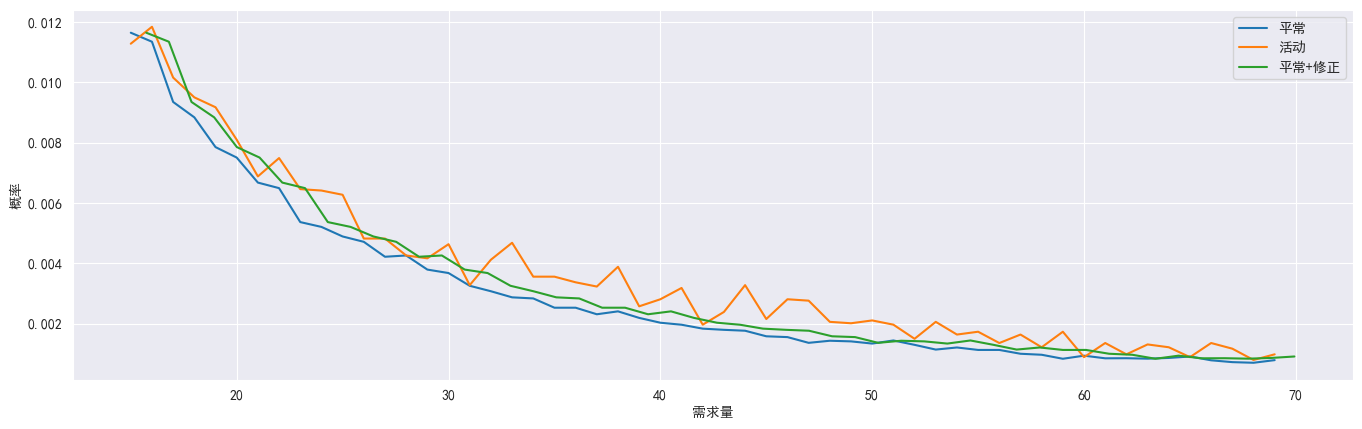

In [317]:
mean_fix = data.copy()
mean_fix["qty"] = mean_fix["qty"].apply(lambda x: k * x ** p)

count3 = mean_fix[["product_no","qty"]].groupby("qty").count()
count3.columns = ["count"]
count3 /= len(mean_fix)

plt.plot(count1[15:70], label = "平常")
plt.plot(count2[15:70], label = "活动")
plt.plot(count3[15:70], label = "平常+修正")

plt.subplots_adjust(left=0, right=2)
plt.xlabel("需求量")
plt.ylabel("概率")
plt.legend()
plt.show()

# 预测

In [284]:
# 滑动窗口预测

def LongTerm(model, step, data_x, first_day=0):
    
    shape_flat = np.prod(data_x.shape)
    
    if shape_flat%(WINDOW*FEATURES) != 0:
        return None
    if shape_flat == 0:
        return None
    
    root = data_x.reshape(-1, WINDOW, FEATURES).squeeze(0)
    
    for i in range(step):
        predict_window = root[-WINDOW:]
        series = root.T[0][-WINDOW:]
        
        predict = model.predict(predict_window.reshape(1, WINDOW*FEATURES))[0]
        predict = max(min(predict, 200), 0)
        series = np.append(series, predict)
        
        mean_5 = series[-5:].mean()
        std_5 = series[-5:].std()
        mean_15 = series[-15:].mean()
        std_15 = series[-15:].std()
        min_15 = series[-15:].min()
        max_15 = series[-15:].max()
        
        d_mean_5 = mean_5 - predict_window.T[1][-1]
        weekend = first_day%7 in [5,6] 
        
        new_col = [predict, mean_5, std_5, mean_15, std_15, min_15, max_15, d_mean_5, weekend]
        #print(new_col)
        
        root = np.append(root, [new_col], axis = 0)
        
    return root.T

In [285]:
# 训练单元

class TrainingUnit:
    
    def __init__(self, data, window, num, model):
        
        if data is not None:
            self.train_x, self.train_y, self.test_x, self.test_y = split_data(data, window, num)
        self.model = model
        
        self.window = window
        
    def train(self):
        
        self.model.fit(self.train_x, self.train_y)
        
    def evalueate_single(self, type_name=None, show_graph=True):
        
        predict = self.model.predict(self.test_x)
        
        if show_graph:
            plt.plot(self.test_y[:300], label='真实值')
            plt.plot(predict[:300],     label='预测值')
            plt.legend()
            plt.xlabel('日期')
            plt.ylabel('需求量' if type_name is None else type_name+"型商家需求量")
            
            plt.subplots_adjust(left=0, right=2)
            plt.show()
        
        mse = np.mean((self.test_y - predict) ** 2)
        print("MSE:",mse)
        print("MIN:",np.mean(np.diff(self.test_y)**2))
        
        return predict, mse
        
    def long_term_predict(self, step, root=None, first_day=0):
        if root is None:
            root = self.test_x[self.window:][0]
            
        result = LongTerm(self.model, step, root, first_day)
        
        return result, root
    
    def evalueate(self, step, predict, real): 
        if predict is None:
            return 0
        
        w_score = WmapeScore(predict[0][self.window:], real[self.window:self.window+step])
        
        return w_score
    
    def evalueate_long(self, step, times=1):
        w_scores = []
        for i in range(1):
            high = len(self.test_x)-self.window*3
            
            offset = np.random.randint(0, min(max(1, high),len(self.test_x)))
            
            if self.test_x[offset+self.window:].shape[0] == 0:
                continue
                
            root = self.test_x[offset+self.window:][0]
            predict, _ = self.long_term_predict(step, root)
            
            if predict is None:
                continue
            
            w_score = self.evalueate(step, predict, self.test_y[offset:])
            w_scores += [w_score]
            
        return np.mean(w_scores)
        
    def show_long(self, result, root, step=15, type_name=None):
        
        plt.plot(root[:self.window+step], label="GT")
        plt.plot(result[0], label="Predict")
        plt.legend()
        
        plt.subplots_adjust(left=0, right=2)
        plt.show()

In [288]:
product_seller = data.set_index("product_no")[["seller_no","date","qty"]]
product_seller["seller t"] = seller_type.loc[product_seller["seller_no"]]["mixed type"].values
product_seller.head()
#seller_type.loc[product_seller["seller_no"]]["mixed type"]

,seller_no,date,qty,seller t
product_no,,,,
product_448,seller_19,2023-05-09,10,C Large
product_448,seller_19,2023-04-17,14,C Large
product_448,seller_19,2023-01-09,2,C Large
product_448,seller_19,2023-01-20,1,C Large
product_448,seller_19,2023-02-13,22,C Large


In [287]:
data.head()

,seller_no,product_no,warehouse_no,date,qty
0,seller_19,product_448,wh_30,2023-05-09,10
1,seller_19,product_448,wh_30,2023-04-17,14
2,seller_19,product_448,wh_30,2023-01-09,2
3,seller_19,product_448,wh_30,2023-01-20,1
4,seller_19,product_448,wh_30,2023-02-13,22


In [289]:
import joblib
import os
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

LinearModels = RFModels = dict()

for root, dirs, files in os.walk("models"):
    print(root, dirs)
    for file in files:
        model_type = file[:-7]
        #print(model_type)]
        
        model = joblib.load("models/"+file)
        
        if "_LR" in file:
            LinearModels[model_type] = TrainingUnit(None, 10, 0, model)
        elif "_RF" in file:
            RFModels[model_type] = TrainingUnit(None, 10, 0, model)
            
RFModels

models []


{'A Large': <__main__.TrainingUnit at 0x1c10e22b1c0>,
 'A Medium': <__main__.TrainingUnit at 0x1c10e22b250>,
 'A Special': <__main__.TrainingUnit at 0x1c10dc48fd0>,
 'B Large': <__main__.TrainingUnit at 0x1c107787df0>,
 'B Medium': <__main__.TrainingUnit at 0x1c10dbed220>,
 'B Small': <__main__.TrainingUnit at 0x1c10dbed430>,
 'B Special': <__main__.TrainingUnit at 0x1c10dbed640>,
 'C Large': <__main__.TrainingUnit at 0x1c10dc56fd0>,
 'D Large': <__main__.TrainingUnit at 0x1c10dc40250>,
 'D Medium': <__main__.TrainingUnit at 0x1c10dc55fd0>}

In [290]:
data3 = data.copy().set_index("product_no")
target = data3.reset_index()[["product_no", "seller_no","warehouse_no"]].drop_duplicates(keep='first')
target = target.set_index("seller_no").sort_index()
target

,product_no,warehouse_no
seller_no,,
seller_10,product_1931,wh_24
seller_10,product_528,wh_1
seller_10,product_1930,wh_13
seller_10,product_534,wh_1
seller_10,product_540,wh_1
...,...,...
seller_9,product_102,wh_13
seller_9,product_95,wh_1
seller_9,product_118,wh_13


In [303]:
Result = pd.DataFrame(columns=["seller_no","product_no","warehouse_no","date","qty"])
Result

predict_data = data[["product_no","warehouse_no","date","qty"]].set_index(["product_no","warehouse_no"]).sort_index()
predict_data["date"] = pd.to_datetime(predict_data["date"])
predict_data = predict_data[predict_data["date"]>="2023-04-20"] # 10+15 days before

count = 0
WINDOW = 10
FEATURES = 9
for seller_no, seller_data in target.reset_index().groupby("seller_no"):
    
    res_all = []
    unit = RFModels[seller_type.loc[seller_no]["mixed type"]]
    
    print(f"    - {seller_no}包含{len(seller_data)}次预测")
    for index, tar in seller_data[["product_no","warehouse_no"]].iterrows():
        product = tar[0]
        wh = tar[1]

        single_series = predict_data.loc[(product, wh)].sort_values(by='date',ascending=True)
        
        single_series["mean 5"] = single_series["qty"].rolling(window=5).mean().fillna(0)
        single_series["std 5"] = single_series["qty"].rolling(window=5).std().fillna(0)
        single_series["mean 15"] = single_series["qty"].rolling(window=15).mean().fillna(0)
        single_series["std 15"] = single_series["qty"].rolling(window=15).std().fillna(0)
        single_series["min 15"] = single_series["qty"].rolling(window=15).min().fillna(0)
        single_series["max 15"] = single_series["qty"].rolling(window=15).max().fillna(0)
        single_series["d mean 5"] = single_series["mean 5"].diff().fillna(0)
        single_series["weekend"] = pd.Index(single_series["date"]).dayofweek.isin([5, 6])
        
        input_data = single_series[["qty","mean 5","std 5","mean 15","std 15","min 15","max 15","d mean 5","weekend"]].values
        input_data = input_data[-WINDOW:].reshape((1,WINDOW*FEATURES))
        
        predict, root = unit.long_term_predict(36, input_data, 1) # first day is Tuesday 
                                                                  # from 2023-5-16 to 2023-6-20 : 16+20=36 days
        first_day = single_series["date"][11]
        predict_series = predict[0][WINDOW:]
        time_series = np.array([first_day + pd.Timedelta(days=15+i) for i in range(36)])
        
        #print(predict_series.shape)
        #print(time_series.shape)
        res = {
            "seller_no" : seller_no,
            "product_no" : product,
            "warehouse_no" : wh,
            "date" : time_series,
            "qty" : predict_series
        }
        res_df = pd.DataFrame(res)
        res_all.append(res_df)

    count+=1
    Result = pd.concat([Result]+res_all, axis=0)
    print(f">>> 预测进度：{count}/{len(target.index.unique())}")
print(">>> 预测完毕")

    - seller_10包含48次预测
>>> 预测进度：1/35
    - seller_11包含195次预测
>>> 预测进度：2/35
    - seller_12包含174次预测
>>> 预测进度：3/35
    - seller_13包含7次预测
>>> 预测进度：4/35
    - seller_14包含126次预测
>>> 预测进度：5/35
    - seller_15包含117次预测
>>> 预测进度：6/35
    - seller_16包含57次预测
>>> 预测进度：7/35
    - seller_17包含15次预测
>>> 预测进度：8/35
    - seller_18包含2次预测
>>> 预测进度：9/35
    - seller_19包含14次预测
>>> 预测进度：10/35
    - seller_2包含42次预测
>>> 预测进度：11/35
    - seller_20包含14次预测
>>> 预测进度：12/35
    - seller_21包含77次预测
>>> 预测进度：13/35
    - seller_22包含39次预测
>>> 预测进度：14/35
    - seller_23包含59次预测
>>> 预测进度：15/35
    - seller_24包含66次预测
>>> 预测进度：16/35
    - seller_25包含63次预测
>>> 预测进度：17/35
    - seller_26包含25次预测
>>> 预测进度：18/35
    - seller_27包含59次预测
>>> 预测进度：19/35
    - seller_28包含147次预测
>>> 预测进度：20/35
    - seller_29包含36次预测
>>> 预测进度：21/35
    - seller_3包含12次预测
>>> 预测进度：22/35
    - seller_30包含28次预测
>>> 预测进度：23/35
    - seller_31包含41次预测
>>> 预测进度：24/35
    - seller_32包含106次预测
>>> 预测进度：25/35
    - seller_33包含93次预测
>>> 预测进度：26/35
    - seller_35包含22

In [310]:
Result_fin = Result[Result["date"] >= "2023-06-01"]
Result_fin["qty"] = Result_fin["qty"].apply(lambda x: k * x ** p)
Result_fin

C:\Users\35041\AppData\Local\Temp\ipykernel_18596\1492143140.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Result_fin["qty"] = Result_fin["qty"].apply(lambda x: k * x ** p)


,seller_no,product_no,warehouse_no,date,qty
16,seller_10,product_1931,wh_24,2023-06-01,17.674625
17,seller_10,product_1931,wh_24,2023-06-02,29.455211
18,seller_10,product_1931,wh_24,2023-06-03,37.309058
19,seller_10,product_1931,wh_24,2023-06-04,32.009583
20,seller_10,product_1931,wh_24,2023-06-05,26.847203
...,...,...,...,...,...
31,seller_9,product_96,wh_1,2023-06-16,11.685914
32,seller_9,product_96,wh_1,2023-06-17,11.600993
33,seller_9,product_96,wh_1,2023-06-18,11.600993
34,seller_9,product_96,wh_1,2023-06-19,11.590379


In [311]:
Result_fin.to_excel('result/result3.xlsx', index=False)